# Quantifying Traditional Indigenous Indicators 

This code was to quantify traditional Indigenous indictors used to know when the burning season starts and stops in the Arnhem Land region of Australia.

## Import libraries:

In [1]:
# Data stuff:
import numpy as np
import pandas as pd
from scipy import stats
import xarray as xr

# Time stuff:
from datetime import datetime
import cftime

# Plotting stuff:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cmo

# Dask:
from dask.distributed import Client

In [2]:
# Start the Dask client
client = Client()
client

Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0045.gadi.nci.org.au/33524/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0045.gadi.nci.org.au/33524/proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45973,Workers: 28
Dashboard: /node/gadi-cpu-bdw-0045.gadi.nci.org.au/33524/proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35953,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0045.gadi.nci.org.au/33524/proxy/46683/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37703,


## Open the data:

Here we give the path to the max temperature ERA5 data, ```mx2t```. You can load whatever temperature data you like, this notebook should work as long as it's loaded into an xarray dataset. 

In [28]:
path = "/g/data/rt52/era5/single-levels/reanalysis/mx2t/*"
#path="/scratch/n81/sg7549/ERA5_temp.nc"

The _preprocess function below is intended to be used as the preprocessing step (preprocess=preprocess_region) in xr.open_mfdataset. It allows us to slice the data to the specified latitude and longitude range, resample the data, and convert the units.

In [26]:
def _preprocess(ds):
    # Select the region of interest by slicing the dataset to the specified latitude and longitude range.
    ds = ds.sel(latitude=slice(-10.25, -16.25), longitude=slice(128.25, 138.25))

    # Resample the dataset to daily frequency and compute the mean for each day.
    ds = ds.resample(time='D').mean(dim='time')

    # Convert the temperature from Kelvin to Celsius.
    ds = ds - 273.15
    return ds

Use xarray's ```open_mfdataset``` to load in the ERA5 data. Here's a description of the steps:

- ```preprocess=_preprocess```: This passes in our _preproces function from above to process the data as it's opened.
- ```parallel=True```: This uses parallel processing to speed up the data loading.
- ```.sel(time=slice('1971', '2022'))```: This slices the data to the years we want.
- ```.chunk(chunks={"time": '2mb',"latitude": -1,"longitude": -1})```: Chunk the dataset for more efficient computation. The time dimension is chunked to 2 megabytes, and latitude and longitude dimensions are not chunked (-1 means no chunking).
- ```.compute()```: Compute the dataset to load it into memory.

In [30]:
#Open ERA5 data from 1971 - 2022 and apply the preprocess_region() function on the data.

era5 = xr.open_mfdataset(path+"/*.nc", preprocess=_preprocess, parallel=True).sel(time=slice('1971', '2022'))
mxt = era5.chunk(chunks={"time": '2mb',"latitude": -1,"longitude": -1})
mxt_e = mxt.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 12.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [8]:
era5_t = xr.open_mfdataset(path, parallel=True)
#mxt = era5_t
#mxt_c = mxt.compute()

In [10]:
mxt_c = era5_t.compute()

View the data:

In [41]:
mxt_c.sel(time=mxt_c.time.dt.year >= 2000, lat=-10.25, lon=128.2, method='nearest').mx2t

<xarray.DataArray 'mx2t' (time: 8401)> Size: 34kB
array([28.612396, 28.636719, 27.82257 , ..., 29.263641, 29.385254,
       29.324432], dtype=float32)
Coordinates:
    lon      float64 8B 128.2
    lat      float64 8B -10.25
  * time     (time) datetime64[ns] 67kB 2000-01-01 2000-01-02 ... 2022-12-31

In [43]:
mxt_e.sel(time=mxt_e.time.dt.year >= 2000, latitude=-10.25, longitude=128.2, method='nearest').mx2t

<xarray.DataArray 'mx2t' (time: 8401)> Size: 67kB
array([27.78219759, 27.88450878, 27.35930231, ..., 28.37679045,
       28.86208513, 29.00051213])
Coordinates:
    longitude  float32 4B 128.2
    latitude   float32 4B -10.25
  * time       (time) datetime64[ns] 67kB 2000-01-01 2000-01-02 ... 2022-12-31

In [14]:
mxt_c_e = mxt_c.sel(time=mxt_c.time.dt.month >= 6)

## Compute the temperature threshold, compute_temp_threshold()

Compute the day of the year when a temperature threshold is first met or exceeded for each year. This function assumes the input dataset has a time dimension and that the temperature variable is named correctly. It filters the data based on the specified condition and threshold, converts it to a pandas DataFrame for easier processing, and then computes the first day of the year when the threshold condition is met for each year.

#### Parameters
- data : **xarray.Dataset**; The input dataset containing the temperature data.
- variable : **str**; The name of the temperature variable in the dataset.
- threshold : **float**; The temperature threshold to compare against.
- year_start : **int**; The start year for the period of interest.
- year_end : **int**; The end year for the period of interest.
- condition : **str**; The condition for comparison, either '<' for temperatures less than the threshold or '>' for temperatures greater than the threshold.

#### Returns
- **pandas.Series**: A Series with the years as the index and the day of the year when the threshold is first met or exceeded as the values. If the threshold is not met in a year, the value will be NaN.
    
#### Raises
- **ValueError**: If the condition parameter is not '<' or '>'.


In [12]:
def compute_temp_threshold(data, variable, threshold, year_start, year_end, condition):
    # Check the condition and create a boolean mask based on the condition
    if condition == '<':
        condition_met = data[variable] <= threshold
    elif condition == '>':
        condition_met = data[variable] >= threshold
    else:
        # Raise an error if the condition is not valid
        raise ValueError("Condition must be '<' or '>'")

    # Apply the boolean mask to the data to filter it
    filtered_data = data.where(condition_met)

    # Convert the filtered data to a pandas DataFrame for easier processing
    df = filtered_data.to_dataframe().reset_index()
    
    # Check if the 'time' column contains cftime objects
    if isinstance(df['time'].iloc[0], cftime.datetime):
        # Extract the year and day of the year from the cftime objects
        df['year'] = df['time'].apply(lambda x: x.year)
        df['dayofyear'] = df['time'].apply(lambda x: x.dayofyr)
    else:
        # Extract the year and day of the year from regular datetime objects
        df['year'] = df['time'].dt.year
        df['dayofyear'] = df['time'].dt.dayofyear

    # Get a list of unique years in the dataset
    unique_years = df['year'].unique()
    # Drop rows with missing values in the specified variable column
    filtered_df = df.dropna(subset=[variable])
    # Group the data by year and find the minimum day of the year for each year
    days_of_year = filtered_df.groupby('year')['dayofyear'].min()
    # Reindex the series to include all years in the range, filling missing values with NaN
    days_of_year_df = days_of_year.reindex(unique_years, fill_value=np.nan)
    
    return days_of_year_df

## Compute the start of the dry period, compute_dry_period_start()

Compute the start date of the first dry period for each year within a specified range. This function assumes the input dataset has a time dimension and that the rainfall variable is named correctly. It identifies the first dry period of the specified length for each year and records the start date.
    
#### Parameters
    
- data : **xarray.Dataset**; The input dataset containing the rainfall data.
- variable : **str**; The name of the rainfall variable in the dataset.
- rainfall_threshold : **float**; The threshold below which a day is considered dry.
- days_threshold : **int**; The number of consecutive dry days required to define a dry period.
- year_start : **int**; The start year for the period of interest.
- year_end : **int**; The end year for the period of interest.
    
#### Returns
    
- **pandas.DataFrame**: A DataFrame with years as the index, and columns for the start date of the dry period and the day of the year when the dry period starts. If no dry period is found for a year, the value will be NaN.

In [16]:
def compute_dry_period_start(data, variable, rainfall_threshold, days_threshold, year_start, year_end):
    # Convert xarray Dataset to pandas DataFrame
    df = data.to_dataframe().reset_index()
    
    # Handling cftime.datetime objects if necessary
    if isinstance(df['time'].iloc[0], cftime.datetime):
        # Convert cftime to Timestamp
        df['time'] = [pd.Timestamp(str(date)) for date in df['time']]  # Convert cftime to Timestamp

    # Ensure data is sorted by time
    df.sort_values('time', inplace=True)

    # Initialize list to store start dates of dry periods
    dry_periods = []

    # Group data by year
    for year, group in df.groupby(df['time'].dt.year):
        # Only process years within the specified range
        if year_start <= year <= year_end:
            # Initialize variables to track the dry period
            dry_period_started = False
            consecutive_days = 0
            found_dry_period = False

            # Iterate through the dates and rainfall values in the group
            for date, value in zip(group['time'].values, group[variable].values):
                if not dry_period_started and value < rainfall_threshold:
                    # Start a new dry period
                    dry_period_started = True
                    start_date = date
                    consecutive_days = 1
                elif dry_period_started and value < rainfall_threshold:
                    # Continue the dry period
                    consecutive_days += 1
                else:
                    # Reset if a wet day is encountered
                    dry_period_started = False
                    consecutive_days = 0

                if consecutive_days >= days_threshold:
                    # Dry period of required length is found
                    dry_periods.append(start_date)
                    found_dry_period = True
                    break

            if not found_dry_period:
                # If no dry period is found for the year, append NaN
                dry_periods.append(np.nan)
    
    # Create a DataFrame from the results
    results = pd.DataFrame({'year': range(year_start, year_end), 'start_date': dry_periods})
    # Compute the day of the year for the start dates
    results['dayofyear'] = results['start_date'].dt.dayofyear

    # Return the results with years as the index
    return results.set_index('year')

## Coordinate names, find_coordinate_names()

Find the coordinate names for latitude and longitude in the given dataset.

#### Parameters

- **data**: xarray.Dataset; The input dataset containing the coordinates.

#### Returns

- **dict**: A dictionary with keys 'latitude' and 'longitude' and their corresponding coordinate names.
    
#### Raises

- **ValueError**: If latitude or longitude coordinate names could not be determined.

In [17]:
def find_coordinate_names(data):

    coord_names = {'latitude': None, 'longitude': None}
    for coord in data.coords:
        if 'lat' in coord.lower():
            coord_names['latitude'] = coord
        if 'lon' in coord.lower():
            coord_names['longitude'] = coord

    if coord_names['latitude'] is None or coord_names['longitude'] is None:
        raise ValueError("Latitude and longitude coordinate names could not be determined.")
    
    return coord_names

## Calculate the trends, calculate_trends_ufunc()

Calculate trends for temperature or rainfall threshold exceedance using linear regression.

#### Parameters

- data : **xarray.Dataset**; The input dataset containing temperature or rainfall data.
- variable : **str**; The name of the variable in the dataset (temperature or rainfall).
- threshold : **float**; The threshold value to compare against.
- year_start : **int**; The start year for the period of interest.
- year_end : **int**; The end year for the period of interest.
- trend : **str**; The type of trend to calculate ('temperature' or 'rainfall').

#### Returns

- **xarray.Dataset**: A dataset containing the slopes and p-values of the trends for each grid point.
    
#### Raises

- **ValueError**: If the trend parameter is not 'temperature' or 'rainfall'.

In [78]:
def calculate_trends_ufunc(data, variable, threshold, year_start, year_end, trend):

    # Find coordinate names
    coord_names = find_coordinate_names(data)
    lat_name = coord_names['latitude']
    lon_name = coord_names['longitude']

    # Creating array of years for the regression
    years_np = np.arange(year_start, year_end) 

    def calc_trend(lat, lon):
        # Calculate the trend for temperature
        if trend == 'temperature':
            days_of_year = compute_temp_threshold(data.sel({lat_name: lat, lon_name: lon}, method='nearest'), 
                                                  variable=variable, threshold=threshold, 
                                                  year_start=year_start, year_end=year_end, condition='<')
        # Calculate the trend for rainfall
        elif trend == 'rainfall':
            days_of_year = compute_dry_period_start(data.sel({lat_name: lat, lon_name: lon}, method='nearest'), 
                                                  variable=variable, threshold=threshold, 
                                                  year_start=year_start, year_end=year_end)
        else:
            # Raise an error if the trend parameter is not valid
            raise ValueError("Invalid trend type. Must be 'temperature' or 'rainfall'.")
        
        # Convert to numpy array and apply mask for linear regression
        days_np = days_of_year.to_numpy()
        mask = ~np.isnan(days_np)
        years_filtered = years_np[mask]
        days_filtered = days_np[mask]
    
        if len(years_filtered) > 0:
            # Perform linear regression to find slope and p-value
            slope, intercept, _, p_value, _ = stats.linregress(years_filtered, days_filtered)
            return slope, intercept, p_value
        else:
            return np.nan, np.nan, np.nan

    # Uses xarray.apply_ufunc for parallel processing to apply the calc_trend function to each grid point in the dataset.
    slopes_p_values = xr.apply_ufunc(
        calc_trend,
        data[lat_name],
        data[lon_name],
        input_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_core_dims=[[], [], []],
        dask_gufunc_kwargs={'output_sizes': {lat_name: len(data[lat_name]), lon_name: len(data[lon_name])}},
        output_dtypes=[np.float64, np.float64, np.float64]
    )

    slopes, intercept, p_values = slopes_p_values

    # Combine slopes and p_values into a single dataset
    result = xr.Dataset({
        'slope': ((lat_name, lon_name), slopes.data),
        'intercept': ((lat_name, lon_name), intercept.data),
        'p_value': ((lat_name, lon_name), p_values.data),
    }, coords={
        lat_name: data[lat_name],
        lon_name: data[lon_name]
    })

    return result

## Calculate the length of the temperature season, calculate_season_ufunc()

Calculate the length of the temperature season based on start and end thresholds and compute trends.

#### Parameters

- data1 : **xarray.Dataset**; The input dataset for the start of the season.
- data2 : **xarray.Dataset**; The input dataset for the end of the season.
- variable : **str**; The name of the variable in the datasets.
- threshold1 : **float**; The threshold value for the start of the season.
- threshold2 : **float**; The threshold value for the end of the season.
- year_start : **int**; The start year for the period of interest.
- year_end : **int**; The end year for the period of interest.

#### Returns

- **xarray.Dataset**: A dataset containing the slopes, p-values, and season lengths for each grid point.

In [19]:
def calculate_season_ufunc(data1, data2, variable, threshold1, threshold2, year_start, year_end):

    # Find coordinate names
    coord_names = find_coordinate_names(data1)
    lat_name = coord_names['latitude']
    lon_name = coord_names['longitude']

    # Creating array of years for the regression
    years_np = np.arange(year_start, year_end) 

    def calc_trend(lat, lon):
        # Calculate the start days of the season
        start_days = compute_temp_threshold(data1.sel({lat_name: lat, lon_name: lon}, method='nearest'), 
                                              variable=variable, threshold=threshold1, 
                                              year_start=year_start, year_end=year_end, condition='<')
        # Calculate the end days of the season
        end_days = compute_temp_threshold(data2.sel({lat_name: lat, lon_name: lon}, method='nearest'), 
                                              variable=variable, threshold=threshold2, 
                                              year_start=year_start, year_end=year_end, condition='>')

        # Calculate the length of the season
        season_length = end_days.fillna(365) - start_days
        #If there is no start day (ie start day = 0), then the season length should be 0
        season_length[start_days == np.nan] = 0
        
        # Convert to numpy array and apply mask for linear regression
        days_np = season_length.to_numpy()
        mask = ~np.isnan(days_np)
        years_filtered = years_np[mask]
        days_filtered = days_np[mask]

         # Perform linear regression if sufficient data points are available
        if len(years_filtered) >= 0.5 * len(days_np):
            slope, intercept, _, p_value, _ = stats.linregress(years_filtered, days_filtered)
            return slope, p_value, season_length
        else:
            return np.nan, np.nan, season_length

     # Use apply_ufunc for parallel processing to apply the calc_trend function to each grid point in the dataset.
    results = xr.apply_ufunc(
        calc_trend,
        data1[lat_name],
        data1[lon_name],
        input_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_core_dims=[[], [], ['year']],
        dask_gufunc_kwargs={'output_sizes': {lat_name: len(data1[lat_name]), lon_name: len(data1[lon_name]), 'year': len(years_np)}},
        output_dtypes=[np.float64, np.float64, np.float64]
    )

    slopes, p_values, season_lengths = results

    # Combine slopes, p_values, and season_lengths into a single dataset
    result = xr.Dataset({
        'slope': ((lat_name, lon_name), slopes.data),
        'p_value': ((lat_name, lon_name), p_values.data),
        'season_length': ((lat_name, lon_name, 'year'), season_lengths.data)
    }, coords={
        lat_name: data1[lat_name],
        lon_name: data1[lon_name],
        'year': years_np
    })

    return result

## Use the above functions to calculate the trends and season length

- Firstly lets calculate the day of the year when a temperature threshold is first met for each year, latitude, and longitude.

In [79]:
%%time

#.isel(latitude=slice(None, None, 2), longitude=slice(None, None, 2))

temp_trend = calculate_trends_ufunc(data=mxt_c, variable="mx2t", threshold=27, year_start=1971, year_end=2023, trend="temperature")

CPU times: user 2.7 s, sys: 219 ms, total: 2.92 s
Wall time: 2.65 s


In [80]:
temp_trend

<xarray.Dataset> Size: 7kB
Dimensions:    (lat: 13, lon: 20)
Coordinates:
  * lat        (lat) float64 104B -10.25 -10.75 -11.25 ... -15.25 -15.75 -16.25
  * lon        (lon) float64 160B 128.2 128.8 129.2 129.8 ... 136.8 137.2 137.8
Data variables:
    slope      (lat, lon) float64 2kB 1.738 1.537 1.418 ... 0.5761 0.7067 0.4695
    intercept  (lat, lon) float64 2kB -3.345e+03 -2.952e+03 ... -855.6
    p_value    (lat, lon) float64 2kB 3.727e-05 0.001873 ... 0.1445 0.2808

- Now lets calculate the season length for the temperature between 2 values, at every year, latitude, and longitude.

In [32]:
%%time
season = calculate_season_ufunc(data1= mxt_c, data2= mxt_c_e ,variable="mx2t", threshold1=27, threshold2=37, year_start=1971, year_end=2023)

CPU times: user 20.2 s, sys: 1.79 s, total: 22 s
Wall time: 19.7 s


In [34]:
season

<xarray.Dataset> Size: 443kB
Dimensions:        (latitude: 25, longitude: 41, year: 52)
Coordinates:
  * latitude       (latitude) float32 100B -10.25 -10.5 -10.75 ... -16.0 -16.25
  * longitude      (longitude) float32 164B 128.2 128.5 128.8 ... 138.0 138.2
  * year           (year) int64 416B 1971 1972 1973 1974 ... 2019 2020 2021 2022
Data variables:
    slope          (latitude, longitude) float64 8kB -1.023 -0.9884 ... -0.8463
    p_value        (latitude, longitude) float64 8kB 0.001481 ... 0.01699
    season_length  (latitude, longitude, year) float64 426kB 347.0 ... 252.0

## Plotting the data

### Make plot for historical trendlines

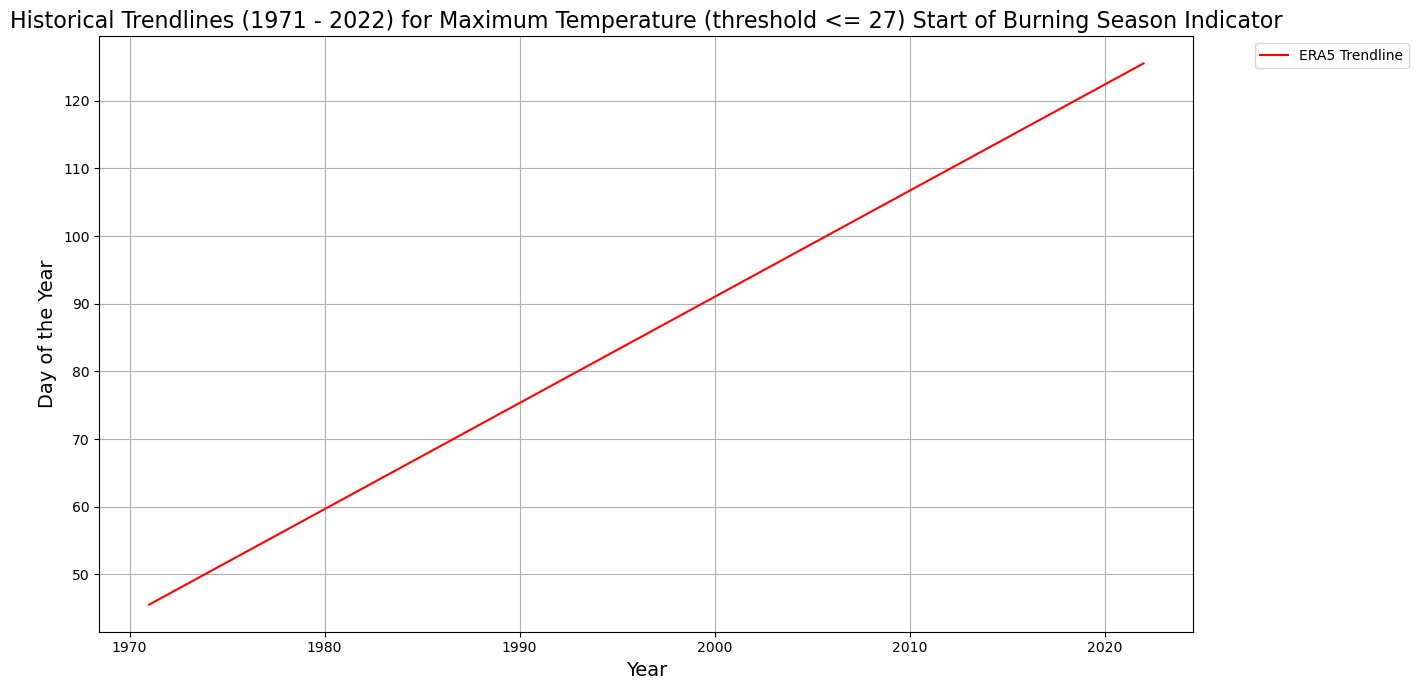

In [94]:
# Define the range of years for the plot
years_r = range(1971, 2023)
                
# Select the data for Bulman region
bulman_lon = 134.33
bulman_lat = -13.66
era5 = temp_trend.sel(lat=bulman_lat, lon=bulman_lon, method='nearest')

# Calculate the trendline using the slope and intercept for each year in the range
era5_line = era5.slope.data * np.array(years_r) + era5.intercept.data

plt.figure(figsize=(14, 7))

# Set the line style based on the p-value: dashed if p-value > 0.05 (not significant), solid otherwise
line_style = '--' if era5.p_value > 0.05 else '-'

plt.plot(years_r, era5_line, color='red', linestyle=line_style, label='ERA5 Trendline')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Day of the Year', fontsize=14)
plt.title('Historical Trendlines (1971 - 2022) for Maximum Temperature (threshold <= 27) Start of Burning Season Indicator', fontsize=16)
plt.grid(True)
# Add a legend to the plot, positioning it outside the main plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Adjust the layout to make room for the legend
plt.tight_layout()

### Plot the trend of maximum temperature data from the ERA5 dataset over the region, regional_plot().

The function identifies and highlights significant trends (p-value <= 0.05) using stippling.

#### Parameters

- data : **xarray.Dataset**; The dataset containing the temperature trend data with coordinates, slope, and p-value.
- title : **str, optional**; The title of the plot (default is 'ERA5 Regional Plot for Maximum Temperature\nStart of Burning Season Indicator (threshold <=27) for 1971-2022').

#### Returns

- **None**: Displays a plot of the temperature trend.

In [68]:
def regional_plot(data, title='ERA5 Regional Plot for Maximum Temperature\nStart of Burning Season Indicator (threshold <=27) for 1971-2022'):

    coord_names = find_coordinate_names(data)
    lat_name = coord_names['latitude']
    lon_name = coord_names['longitude']

    bulman_lon = 134.33
    bulman_lat = -13.66
    
    fig = plt.figure(figsize=(8, 4))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cft.OCEAN, edgecolor='black', facecolor='lightgray')
    ocean_50m = cft.NaturalEarthFeature('physical', 'ocean', '10m',
                                   edgecolor='black', facecolor='white', linewidth=0.5)
    ax.add_feature(ocean_50m)

    cmap_rdbu = colormaps['RdBu_r']
    cmap_rdbu.set_bad('#cccccc')

    data['slope'].plot(ax=ax,
                      x=lon_name, y=lat_name,
                      cmap=cmap_rdbu,
                      cbar_kwargs={'label': 'Rate of change of indicator (days/year)',
                                   'fraction': 0.03,
                                   'aspect': 15,
                                   'shrink': 0.7})

    ax.set_extent([data[lon_name].values.min(), data[lon_name].values.max(), data[lat_name].values.min(), data[lat_name].values.max()], crs=ccrs.PlateCarree())

    ax.scatter(bulman_lon, bulman_lat, color='black', s=20, label='Bulman')
    ax.text(bulman_lon + 0.2, bulman_lat, 'Bulman', transform=ccrs.PlateCarree(), fontsize=8, color='black')

    significant_mask = (data.p_value <= 0.05)
    lat_indices, lon_indices = np.where(significant_mask)

    lat_step = np.abs(data[lat_name].values[1] - data[lat_name].values[0]) / 2
    lon_step = np.abs(data[lon_name].values[1] - data[lon_name].values[0]) / 2
    offsets = np.array([[-lat_step / 2, -lon_step / 2], [-lat_step / 2, lon_step / 2], 
                        [lat_step / 2, -lon_step / 2], [lat_step / 2, lon_step / 2]])

    # Get the cell coordinates
    cell_lats = np.array(data[lat_name].values[lat_indices])
    cell_lons = np.array(data[lon_name].values[lon_indices])

    # Create the stippling coordinates
    stippling_lats = cell_lats[:, np.newaxis] + offsets[:, 0]
    stippling_lons = cell_lons[:, np.newaxis] + offsets[:, 1]

    # Flatten the arrays and plot
    ax.scatter(stippling_lons.flatten(), stippling_lats.flatten(), color='green', s=10, marker='.', transform=ccrs.PlateCarree())

    plt.title(title)
    plt.show()

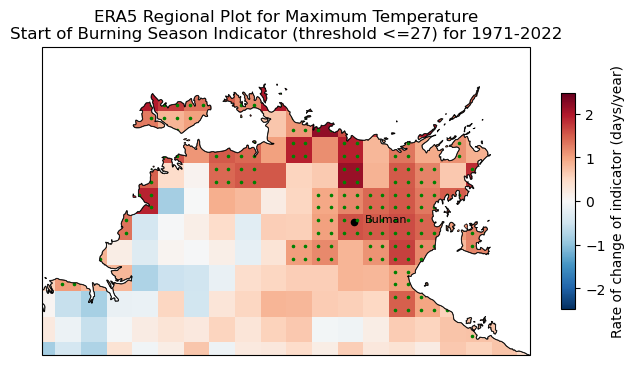

In [71]:
regional_plot(temp_trend)